In [ ]:
#data cleaning, importing, etc
#note: this dataset csv is close to 3gb in size. it may take well over a minute to load.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.float_format', '{:.2f}'.format)

df = pd.DataFrame()
try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
except ImportError:
    print("kagglehub not found. Run pip install kagglehub in your terminal")
try:
    print("Downloading dataset from Kaggle...")
    folder = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
    df = pd.read_csv(folder + "/US_Accidents_March23.csv", encoding="latin1", low_memory=False)
    print("Dataset loaded successfully.")
except Exception as e:
    print("KaggleHub download failed:", e)
    
    
# first, drop columns with >50% missing data

df = df.dropna(axis=1, thresh=len(df) / 2)

# next datetime stuff

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.day_name()


rows_with_nans = df.isnull().any(axis=1).sum()
print("Rows with missing values before cleaning:", rows_with_nans)

# next just fill numeric columns with median fales
count = 0
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())
        count += 1

# then for NaNs in categorical items just do mode
categorical_cols = df.select_dtypes(exclude=np.number).columns
for col in categorical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])
        count += 1



print("Total rows:", len(df))
print("Total columns:", len(df.columns))
print("Any NaNs left?", df.isnull().sum().sum() > 0)   

 

Dataset loaded successfully.
Rows with missing values before cleaning: 4864129
Total rows: 7728394
Total columns: 50
Any NaNs left? False


Contingency table:
Sunrise_Sunset      Day    Night
Severe                          
0               4302278  1922069
1               1055521   448526

Chi Squared =  638.277, p =  7.9177e-141, dof = 1
Expected frequencies:
Sunrise_Sunset        Day      Night
Severe                              
0              4315100.93 1909246.07
1              1042698.07  461348.93


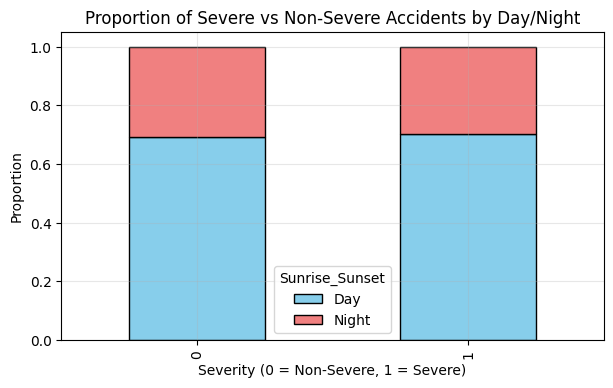

In [ ]:
# Chi Squared Test
# Severity vs Day/Night
# Is the severity of accident independent of daylight?


df['Severe'] = (df['Severity'] >= 3).astype(int) # note the dataset ranks severity 1-4

table = pd.crosstab(df['Severe'], df['Sunrise_Sunset'])
chi2, p, dof, expected = stats.chi2_contingency(table)

print("Contingency table:")
print(table)
print(f"\nChi Squared = {chi2: .3f}, p = {p: .4e}, dof = {dof}")
print("Expected frequencies:")
print(pd.DataFrame(expected, index=table.index, columns=table.columns))

proportions = (table.T / table.T.sum()).T

proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(7,4),
    color=['skyblue', 'lightcoral'],
    edgecolor='black'
)

plt.title('Proportion of Severe vs Non-Severe Accidents by Day/Night')
plt.xlabel('Severity (0 = Non-Severe, 1 = Severe)')
plt.ylabel('Proportion')
plt.legend(title='Sunrise_Sunset')
plt.grid(alpha=0.3)
plt.show()

The text produced a chi squared of 638.28 with 1 degree of freedom and p = 7.9 * 10^(-141).

Since p < 0.05, we reject the null hypothesis that accident severity is independent of daylight conditions. There is a statistically significant relationship between time of day and accident severity.

Although both daytime and nighttime have large numbers of accidents, the proportion of severe accidents is slightly higher during the day than it would be if evenly distributed.

This could be a reflection of the much greater volume of daytime traffic. More vehicles on the road increases the probability of high-impact collisions even though (generally) driving conditions are better. With more cars on the road, there are more things to hit.

The stacked bar chart shows the proportions of severe vs non-severe accidents. While the percentage seems relatively small, the datasets size of over 7 million collisions makes this pattern statistically meaningful.



Trimmed visibility outside [0.5, 10.0] mi — removed 81,838 rows.
Pearson correlation:  r = -0.0146, p-value = 0.000e+00
Spearman correlation: r = -0.0162, p-value = 0.000e+00


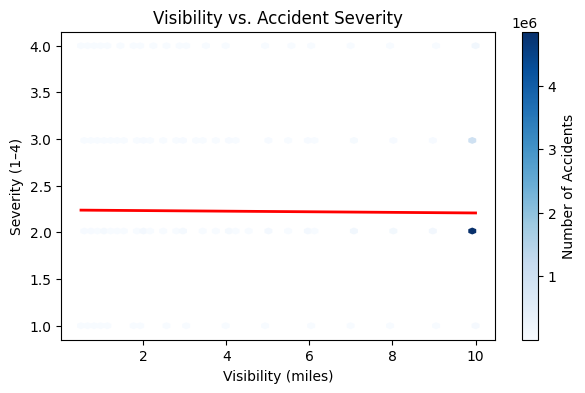

In [ ]:
# Correlation analysis between visibility and accident severity

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
corr_df = df[['Visibility(mi)', 'Severity']].dropna().copy()
corr_df['Severity'] = pd.to_numeric(corr_df['Severity'], errors='coerce')
corr_df = corr_df.dropna()

lo, hi = corr_df['Visibility(mi)'].quantile([0.01, 0.99])
trim = corr_df[(corr_df['Visibility(mi)'] >= lo) & (corr_df['Visibility(mi)'] <= hi)]
removed = len(corr_df) - len(trim)
print(f"Trimmed visibility outside [{lo:.1f}, {hi:.1f}] mi — removed {removed:,} rows.")

pearson_r, pearson_p = pearsonr(trim['Visibility(mi)'], trim['Severity'])
spearman_r, spearman_p = spearmanr(trim['Visibility(mi)'], trim['Severity'])

print(f"Pearson correlation:  r = {pearson_r:.4f}, p-value = {pearson_p:.3e}")
print(f"Spearman correlation: r = {spearman_r:.4f}, p-value = {spearman_p:.3e}")

plt.figure(figsize=(7,4))
hb = plt.hexbin(trim['Visibility(mi)'], trim['Severity'], gridsize=60, cmap='Blues', mincnt=1)
plt.colorbar(label='Number of Accidents')
plt.xlabel('Visibility (miles)')
plt.ylabel('Severity (1–4)')
plt.title('Visibility vs. Accident Severity')

x = trim['Visibility(mi)'].to_numpy()
y = trim['Severity'].to_numpy()
b1, b0 = np.polyfit(x, y, 1)
xline = np.linspace(x.min(), x.max(), 100)
plt.plot(xline, b1 * xline + b0, color='red', linewidth=2)
plt.show()


CA vs TX
CA: 285,316/1,741,433 = 16.38% severe
TX: 127,652/582,837 = 21.90% severe
Difference: -5.52%
z = -95.39, p = 0.000e+00


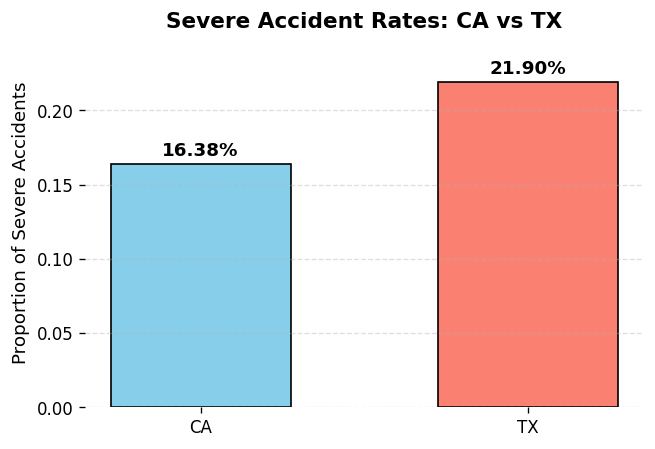

In [ ]:
# hypothesis test of severity of accidents between California and Texas
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import numpy as np

def compare_state_severity(df, state_a='CA', state_b='TX'):
    df['Severe'] = (df['Severity'] >= 3).astype(int)

    # severe accidents
    counts = np.array([
        df.query("State == @state_a")['Severe'].sum(),
        df.query("State == @state_b")['Severe'].sum()
    ])
    
    # total accidents
    nobs = np.array([
        len(df.query("State == @state_a")),
        len(df.query("State == @state_b"))
    ])

    p1, p2 = counts[0]/nobs[0], counts[1]/nobs[1]
    z, p = proportions_ztest(counts, nobs)

    print(f"{state_a} vs {state_b}")
    print(f"{state_a}: {counts[0]:,}/{nobs[0]:,} = {p1*100:.2f}% severe")
    print(f"{state_b}: {counts[1]:,}/{nobs[1]:,} = {p2*100:.2f}% severe")
    print(f"Difference: {(p1 - p2)*100:.2f}%")
    print(f"z = {z:.2f}, p = {p:.3e}")



    plt.figure(figsize=(6,4), dpi=120)
    bars = plt.bar([state_a, state_b], [p1, p2],
                   color=['skyblue','salmon'], edgecolor='black', width=0.55)

    for i, v in enumerate([p1, p2]):
        plt.text(i, v + 0.003, f"{v*100:.2f}%", ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

    plt.ylim(0, max(p1,p2)+0.03)
    plt.ylabel("Proportion of Severe Accidents", fontsize=11)
    plt.title(f"Severe Accident Rates: {state_a} vs {state_b}", fontsize=13, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.box(False)
    plt.show()

compare_state_severity(df, 'CA', 'TX')


To test whether the proportion of severe accidents (severity >= 3) differs between California and Texas, a two-proportion z-test was performed.

The p-value is far below .05 so we reject the null hypothesis that both tstates have equal rates of severe accidents. Statistically, Texas has a significantly higher proportion of severe accidents than California. 